## Планы:
1. Можно описать в ноутбуке каждый из классов

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from utils import (
    train_template,
    get_metrics, 
    random_forest_train, 
    xgboost_train, 
    catboost_train
)

/home/lazarev/.local/lib/python3.7/site-packages/pkg_resources/__init__.py:125: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


In [3]:
# help(train_template)

## Data loading/proccessing

### 38 peaks data proccessing

In [5]:
def data_loading(first_file, second_file):
    data_ga = pd.read_csv(first_file, sep=";", header=None)
    data_fg = pd.read_csv(second_file, sep=";", header=None)
    columns = data_ga.columns.values
#     print(f"data with GA samples shape: {data_ga.shape}")
#     print(f"data with FG samples shape: {data_fg.shape}")
    y_fg = data_fg[columns[0]].values
    X_fg = data_fg.drop(columns=columns[0])

    y_ga = data_ga[columns[0]].values
    X_ga = data_ga.drop(columns=columns[0])
#     print(f"shapes of X and y of FG samples respectively is: {X_fg.shape}, {y_fg.shape}")
#     print(f"shapes of X and y of GA samples respectively is: {X_ga.shape}, {y_ga.shape}")
    
#     print(f"old fg classes: {set(y_fg)}")
    for index, element in enumerate(set(y_fg)):
        y_fg[y_fg == element] = index
#     print(f"new fg classes: {set(y_fg)}\n")

#     print(f"old ga classes: {set(y_ga)}")
    for index, element in enumerate(set(y_ga)):
#         print(index, index+len(set(y_fg)))
        y_ga[y_ga == element] = index + len(set(y_fg))
#     print(f"new ga classes: {set(y_ga)}")
    
    group1 = [0, 1, 2, 3, 4]
    group2 = [5, 6, 7, 8, 9]
    group3 = [10, 11]
    group4 = [12, 13]
    groups = [group1, group2, group3, group4]

    def add_group(y, groups):
        new_y = np.zeros((y.shape[0], 2))
        new_y[:, 1] = y
        for group_num, group in enumerate(groups):
            for class_num in group:
                new_y[y==class_num] = np.array([group_num, class_num])
        return new_y
    
    y = np.concatenate((y_fg, y_ga), axis=0)
    X = np.concatenate((X_fg, X_ga), axis=0)
    
    X = X.reshape(X.shape[0], 1, -1)
    y = add_group(y, groups)
    print(f"shapes of X and y is respectively: {X.shape}, {y.shape}")
    
    return X, y

X, y = data_loading("dataSrc/peaks-ga-105nonsign.csv", "dataSrc/peaks-fg-105nonsign.csv")

ParserError: Error tokenizing data. C error: Expected 35 fields in line 4, saw 36


In [322]:
def class_balance(y):
    print(np.unique(y[:, 1]))
    new_y = y[:, 1].copy()
    if np.unique(new_y).shape[0] != new_y.max() + 1:
        for index, class_i in enumerate(np.unique(new_y)):
            new_y[new_y == class_i] = index
    plt.figure(figsize=(16, 9), dpi=200)
    plt.hist(new_y, bins=np.unique(new_y).shape[0], rwidth=0.8)
#     plt.title('Balance of classes', fontsize=20)
    print(np.unique(new_y))
    plt.xticks(
        ticks=np.linspace(0.4, 5.6, np.unique(new_y).shape[0]), 
        labels=[str(i+1) + ' class' for i in range(np.unique(new_y).shape[0])], 
        fontsize=15
    )

[ 0.  1.  2.  3.  4. 10. 11.]
[0. 1. 2. 3. 4. 5. 6.]


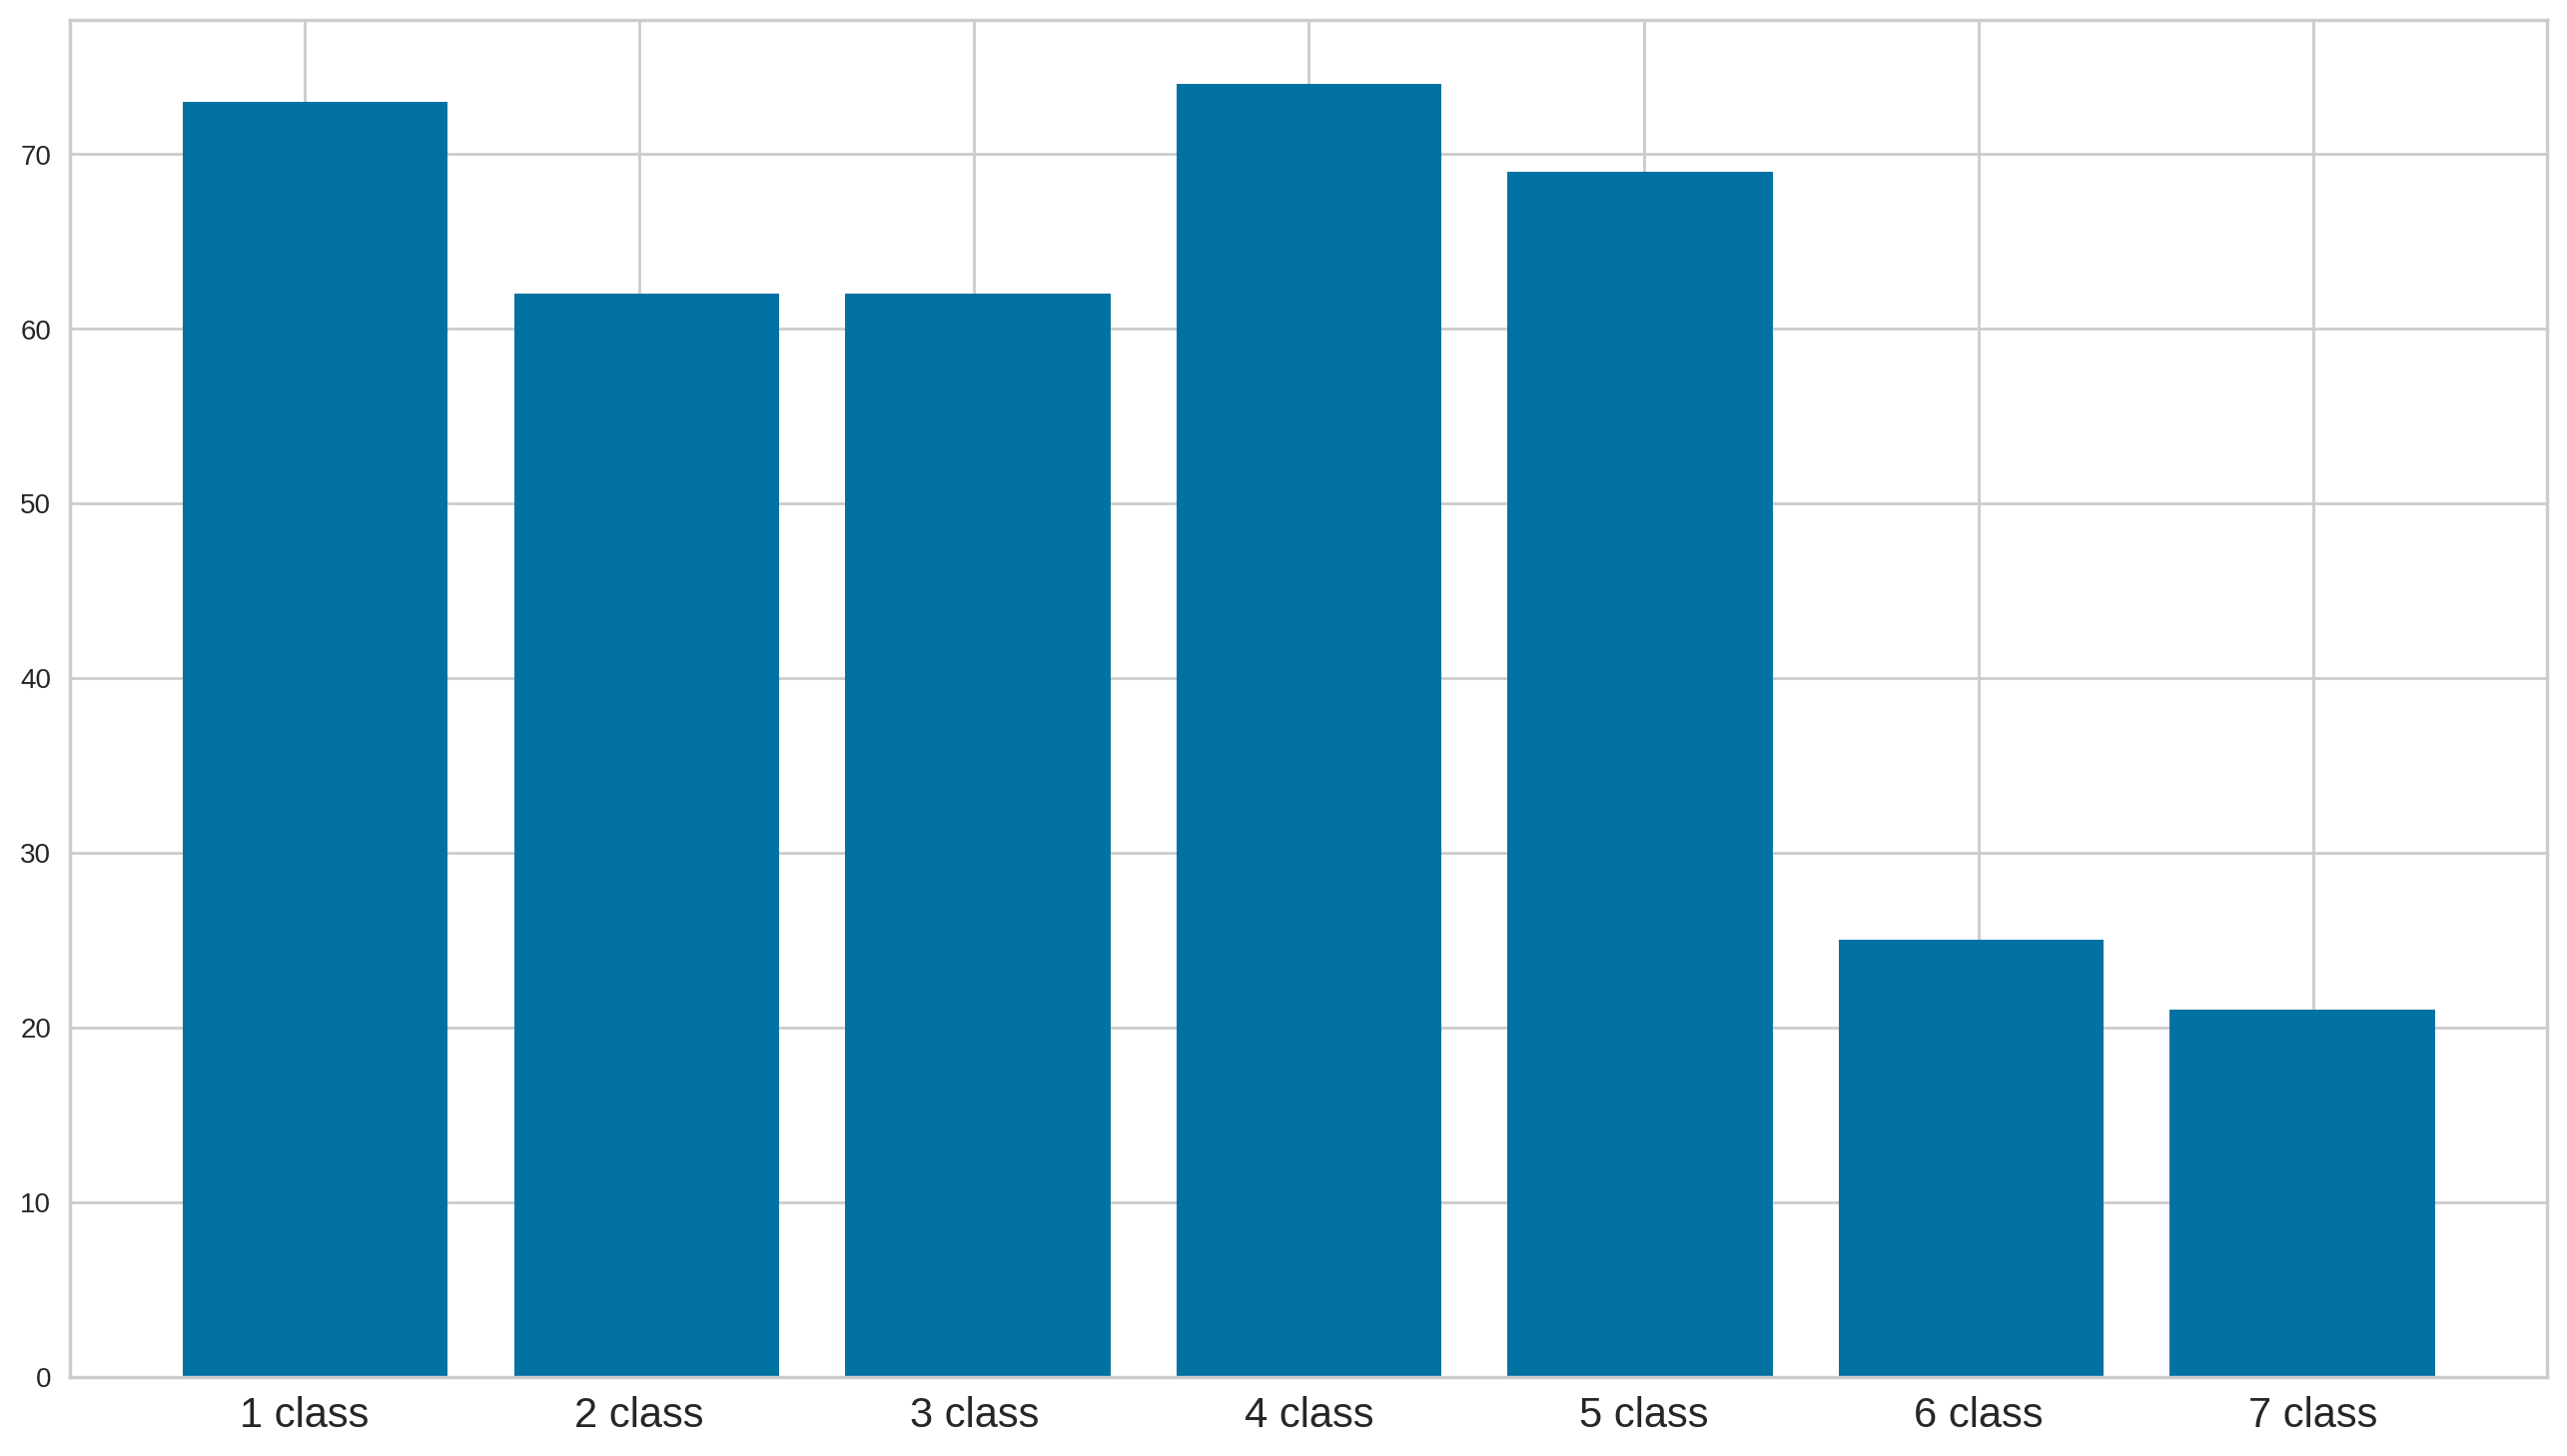

In [325]:
class_balance(y)

### Разделим датасет на два датасета

In [291]:
def split_dataset(
    X=None, 
    y=None, 
    first_file="dataSrc/peaks-ga-38nonsign.csv", 
    second_file="dataSrc/peaks-fg-38nonsign.csv"
):
    if X is None and y is None:
        X, y = data_loading(first_file, second_file)
    first_dataset_classes = [0, 1, 2, 3, 4, 10, 11]
    second_dataset_classes = [5, 6, 7, 8, 9, 12, 13]
    
    first_x = np.array([]).reshape((0, X.shape[1], X.shape[2]))
    first_y = np.array([]).reshape((0, y.shape[1]))
    for i in first_dataset_classes:
#         print(i)
        first_x = np.concatenate((first_x, X[y[:, 1] == i]), axis=0)
        first_y = np.concatenate((first_y, y[y[:, 1] == i]), axis=0)

    second_x = np.array([]).reshape((0, X.shape[1], X.shape[2]))
    second_y = np.array([]).reshape((0, y.shape[1]))
    for i in second_dataset_classes:
#         print(y[y[:, 1] == i])
        second_x = np.concatenate((second_x, X[y[:, 1] == i]), axis=0)
        second_y = np.concatenate((second_y, y[y[:, 1] == i]), axis=0)
        
    print(first_x.shape, first_y.shape, second_x.shape, second_y.shape)
    return first_x, first_y, second_x, second_y

## Применение методов ml

In [328]:
num_estimators = 1000

In [334]:
# X, y = data_loading("dataSrc/ga_2_3_5_6.csv", "dataSrc/fg_1-5_7-11.csv")
first_x, first_y, second_x, second_y = split_dataset()
# X, y = first_x, first_y
X, y = second_x, second_y

shapes of X and y is respectively: (658, 1, 38), (658, 2)
(386, 1, 38) (386, 2) (272, 1, 38) (272, 2)


### Random Forest

In [335]:
_, _ = random_forest_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    num_estimators=num_estimators,
    class_type='group', 
    description='38 peaks dataset using RandomForest on(for) group prediction', 
    file_name='metrics/metrics_random_forest_38_gauss_peaks_groups.txt'
)
metric_dict, models = random_forest_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    num_estimators=num_estimators,
    class_type='class', 
    description='38 peaks dataset using RandomForest on class prediction', 
    file_name='metrics/metrics_random_forest_38_gauss_peaks_classes.txt'
)

Metrics on 38 peaks dataset using RandomForest on(for) group prediction:
mean accuracy           = 0.994 +- 0.006
mean f1 weighted        = 0.994 +- 0.006
mean precision weighted = 0.994 +- 0.006
mean recall weighted    = 0.994 +- 0.006
mean f1 macro           = 0.977 +- 0.021
mean precision macro    = 0.979 +- 0.021
mean recall macro       = 0.977 +- 0.021

    
Metrics on 38 peaks dataset using RandomForest on class prediction:
mean accuracy           = 0.888 +- 0.023
mean f1 weighted        = 0.887 +- 0.023
mean precision weighted = 0.894 +- 0.021
mean recall weighted    = 0.888 +- 0.023
mean f1 macro           = 0.895 +- 0.023
mean precision macro    = 0.903 +- 0.021
mean recall macro       = 0.895 +- 0.023

    


In [336]:
# metric_dict

### Градиентный бустинг от XGBoost

In [337]:
# in order to ignore all the warning messages
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

_, _ = xgboost_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    num_estimators=num_estimators,
    class_type='group', 
    description='38 peaks dataset using XGBoost on group prediction', 
    file_name='metrics/metrics_xgboost_38_gauss_peaks_groups.txt'
)
_, _ = xgboost_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1],
    num_estimators=num_estimators,
    class_type='class', 
    description='38 peaks dataset using XGBoost on class prediction', 
    file_name='metrics/metrics_xgboost_38_gauss_peaks_classes.txt'
)

Metrics on 38 peaks dataset using XGBoost on group prediction:
mean accuracy           = 0.982 +- 0.006
mean f1 weighted        = 0.982 +- 0.006
mean precision weighted = 0.984 +- 0.006
mean recall weighted    = 0.982 +- 0.006
mean f1 macro           = 0.934 +- 0.021
mean precision macro    = 0.946 +- 0.018
mean recall macro       = 0.932 +- 0.023

    
Metrics on 38 peaks dataset using XGBoost on class prediction:
mean accuracy           = 0.842 +- 0.018
mean f1 weighted        = 0.84 +- 0.018
mean precision weighted = 0.855 +- 0.016
mean recall weighted    = 0.842 +- 0.018
mean f1 macro           = 0.836 +- 0.023
mean precision macro    = 0.856 +- 0.016
mean recall macro       = 0.839 +- 0.024

    


### Градиентный бустинг от CatBoost

In [338]:
_, _ = catboost_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    num_estimators=num_estimators,
    class_type='group', 
    description='38 peaks dataset using CatBoost on group prediction', 
    file_name='metrics/metrics_catboost_38_gauss_peaks_groups.txt'
)
_, _ = catboost_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    num_estimators=num_estimators,
    class_type='class', 
    description='38 peaks dataset using CatBoost on class prediction', 
    file_name='metrics/metrics_catboost_38_gauss_peaks_classes.txt'
)

Metrics on 38 peaks dataset using CatBoost on group prediction:
mean accuracy           = 0.989 +- 0.004
mean f1 weighted        = 0.989 +- 0.004
mean precision weighted = 0.99 +- 0.004
mean recall weighted    = 0.989 +- 0.004
mean f1 macro           = 0.961 +- 0.013
mean precision macro    = 0.962 +- 0.014
mean recall macro       = 0.962 +- 0.014

    
Metrics on 38 peaks dataset using CatBoost on class prediction:
mean accuracy           = 0.892 +- 0.024
mean f1 weighted        = 0.891 +- 0.025
mean precision weighted = 0.905 +- 0.021
mean recall weighted    = 0.892 +- 0.024
mean f1 macro           = 0.905 +- 0.021
mean precision macro    = 0.918 +- 0.018
mean recall macro       = 0.905 +- 0.021

    


## Полные данные о гауссианах(114 фичей)

In [ ]:
# fixed_fg_file, fixed_ga_file = "dataSrc/peaks-fg-114nonsign.csv", "dataSrc/peaks-ga-114nonsign.csv"

# data_fixed_fg = pd.read_csv(fixed_fg_file, sep=";", header=None)
# data_fixed_ga = pd.read_csv(fixed_ga_file, sep=";", header=None)
# columns = data_fixed_fg.columns
# print(f"""data with fixed peaks FG shape: {data_fixed_fg.shape}
# data with fixed peaks GA shape: {data_fixed_ga.shape}""")

In [235]:
# y_fg = data_fixed_fg[columns[0]].values
# print(f"old classes: {set(y_fg)}")
# for index, element in enumerate(set(y_fg)):
#     y_fg[y_fg == element] = index
# print(f"new classes: {set(y_fg)}\n")

# y_ga = data_fixed_ga[columns[0]].values
# print(f"old ga classes: {set(y_ga)}")
# for index, element in enumerate(set(data_fixed_ga[columns[0]])):
#     y_ga[y_ga == element] = index + len(set(y_fg))
# print(f"new ga classes: {set(y_ga)}")

In [236]:
# group1 = [0, 1, 2, 3, 4]
# group2 = [5, 6, 7, 8, 9]
# group3 = [10, 11]
# group4 = [12, 13]
# groups = [group1, group2, group3, group4]

# def add_group(y, groups, add=0):
#     new_y = np.zeros((y.shape[0], 2))
#     new_y[:, 1] = y
#     for group_num, group in enumerate(groups):
#         for class_num in group:
#             new_y[y==class_num] = np.array([group_num + add, class_num])
#     return new_y

# y_ga = add_group(y_ga, (group3, group4), add=2)
# y_fg = add_group(y_fg, (group1, group2))
# print(f"Now, shapes of y_fg and ga is respectively: {y_ga.shape}, {y_fg.shape}")

In [237]:
# X_fixed = np.concatenate(
#     (
#     data_fixed_fg[columns[1:]],
#     data_fixed_ga[columns[1:]]
#     )
#     , axis=0
# )
# y_fixed = np.concatenate(
#     (
#     y_fg,
#     y_ga
#     )
#     , axis=0
# )

# print(f"shapes of X and y is respectively: {X_fixed.shape}, {y_fixed.shape}")

In [238]:
# def random_forest_train(data, y, num_features, description='data_cut dataset', class_type='group'):
#     if class_type not in ('group', 'class'):
#         raise Exception("class_type may be equal only 'group' or 'class'")
#     exrt_crystal_system = ExtraTreesClassifier(
#         n_estimators=2000, 
#         max_depth=40, 
#         max_features=num_features, 
#         n_jobs=-1, 
#     #     random_state=random_state,
#         warm_start=False
#     )
    
#     train_template(exrt_crystal_system, data, y, description, class_type)

In [239]:
# random_forest_train(
#     X_fixed, 
#     y_fixed, 
#     X_fixed.shape[1], 
#     class_type='group', 
#     description='114 peaks dataset'
# )
# random_forest_train(
#     X_fixed, 
#     y_fixed, 
#     X_fixed.shape[1], 
#     class_type='class', 
#     description='114 peaks dataset'
# )

In [240]:
# # !pip install xgboost
# import xgboost as xgb

# def xgboost_train(data, y, num_features, description='data_cut dataset', class_type='group'):
#     if class_type not in ('group', 'class'):
#         raise Exception("class_type may be equal only 'group' or 'class'")
    
#     xg_clsfr = xgb.XGBClassifier(
#         objective='multi:softmax', 
#         learning_rate = 0.01,
# #         max_depth = 50, 
# #         reg_alpha = 0, 
# #         reg_lambda=0, 
#         n_estimators = 200, 
#         eval_metric='merror'
# #         num_class=7, 
# #         tree_method = "hist", 
# #         verbosity=0, 
# #         grow_policy="lossguide"
#     )
#     train_template(xg_clsfr, data, y, description, class_type)

In [241]:
# # in order to ignore all the warning messages
# import warnings
# warnings.filterwarnings('ignore')
# # warnings.filterwarnings(action='once')

# xgboost_train(X_fixed, 
#               y_fixed, 
#               X_fixed.shape[1], 
#               class_type='group', 
#               description='114 peaks dataset')
# xgboost_train(X_fixed, 
#               y_fixed, 
#               X_fixed.shape[1], 
#               class_type='class', 
#               description='114 peaks dataset')

In [242]:
# # !pip install catboost
# import catboost

# def catboost_train(data, y, num_features, description='data_cut dataset', class_type='group'):
#     if class_type not in ('group', 'class'):
#         raise Exception("class_type may be equal only 'group' or 'class'")
    
# #     yes, I love cats
#     kitty_model = catboost.CatBoostClassifier(
#         iterations = 200,
# #         if you want to see logs, set 'veerbose' to 1 or 2
#         verbose=0
#     )
    
#     train_template(kitty_model, data, y, description, class_type)

In [243]:

# catboost_train(X_fixed, 
#               y_fixed, 
#               X_fixed.shape[1], 
#               class_type='group', 
#               description='114 peaks dataset')
# catboost_train(X_fixed, 
#               y_fixed, 
#               X_fixed.shape[1], 
#               class_type='class', 
#               description='114 peaks dataset')

In [244]:
# kitty_model = catboost.CatBoostClassifier(
#         iterations = 100,
# #         if you want to see logs, set 'veerbose' to 1 or 2
#         verbose=0
#     )

# print_roc(X_fixed, y_fixed, kitty_model, "gaussuain full data", "GaussianFullDataAnalysys")

## Метрики